# Tutorial on inference with SPEXAI

This tutorial explains how you can use SPEXAI to fit observered spectra from a FITS file.

In [1]:
import numpy as np
from spexai import Fit, TwoTemp, TempDist

## Fitting an One-Temperature Model

Simulated data or real data can be model with a one temperuture model by  ```Fit```

The paramater that are fitted are the 
- Temperature in KeV  ```temp``` (between 0.2 and 10 KeV)
- Metalicity [solar] ```met```  (larger then 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- Normalisation ```norm``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [3]:
#intial guess and prior for fit
prior = {
        'temp': {'mu': 5,    'sigma': 2},
        'met' : {'mu': 1,    'sigma': .3},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -5,   'sigma': 2},
        'norm': {'mu': 1e10, 'sigma': 1e9}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, ```prior``` indicates the intial values for the parameters and there Gaussion prior in the likelihood, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min``` > 0.1; ```e_max``` < 25).

```fdir_nn``` is the file directory to the trained neural networks and should match the path on your device.

In [4]:
#initialize the
fit = Fit(50, 800, prior, Luminosity_Distance=1e25, fdir_nn='/home/jmatthijss/spexai_code/neuralnetworks/', e_max=15)

Using cuda


### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF).

The data used for fitting can be read in from a FITS file of the observed data ```Fit.load_data```, or can be simulated by the model with ```Fit.sim_data(params)``` here ```params``` is a dictornary with the parameter names and there values.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [5]:
'''This step can take a long time to run'''
#reading in the response matrix file
fit.combined_model.load_rm('/home/jmatthijss/data/volume_2/MasterProject/Data_old/ARF_RMF/resolve_h5ev_2019a.rmf')

In [6]:
#reading in the effective area
fit.combined_model.load_arf('/home/jmatthijss/data/volume_2/MasterProject/Data_old/ARF_RMF/resolve_pnt_spec_noGV_20190611.arf')

In [7]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
fit.combined_model.load_sparsematrix_x(n=200)

In [8]:
#create your own data
params = {'temp':5,'logz':-2, 'vel':100, 'met':1.2, 'norm':1e10, 'Z8':1.2, 'Z14':0.9}
fit.sim_data(params, exp_time=50000)

__Add aditional parameters__

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [9]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

### Run Ensemble Sampler Fit

Then after ensemble sampler has been fully intialized the data can be fitted with ```Fit.fit_spectra``` making use of ```emcee``` algorithm.
```Fit.fit_spectra``` will also print the integrated autocorrelation time to give an indication of the burn-in time.

In [10]:
'''This step can take a long time to run'''
np.seterr(all="ignore")#ignore RuntimeWarning error prints
fit.fit_spectra(add_prior=add_prior)

  5%|▌         | 30/600 [05:24<1:42:41, 10.81s/it]Traceback (most recent call last):
  File "/home/jmatthijss/.local/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/jmatthijss/spexai_code/spexai/inference/fit.py", line 322, in log_prob
    return self.log_likelihood(data, model, params), derived
  File "/home/jmatthijss/spexai_code/spexai/inference/fit.py", line 208, in log_likelihood
    ymodel = model(temp, dict_abund, params['logz'],  params['norm'], params['vel'])
  File "/home/jmatthijss/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jmatthijss/spexai_code/spexai/inference/model.py", line 128, in forward
    output = self.broadening(y.flatten(), velocity).flatten()
  File "/home/jmatthijss/spexai_code/spexai/inference/model.py", line 95, in broadening
    normal_matrix = torch.sparse.mm(normilisation.to

emcee: Exception while calling your likelihood function:
  params: [ 6.02169538e+00  5.04261725e-01  2.30613824e+02 -3.97236877e+00
  1.15762936e+09  1.10121444e+00  6.73205701e-01]
  args: []
  kwargs: {'param_names': ['temp', 'met', 'vel', 'logz', 'norm', 'Z8', 'Z14'], 'data': array([0, 0, 0, ..., 0, 0, 0]), 'model': CombinedModel(
  (models): ModuleDict(
    (Z1): FFN(
      (act_fn): ModuleDict(
        (sigmoid): Sigmoid()
        (relu): ReLU()
        (elu): ELU(alpha=1.0)
        (softmax): Softmax(dim=None)
        (sofltpus): Softplus(beta=1, threshold=20)
        (tanh): Tanh()
      )
      (layers): Sequential(
        (dropout0): Dropout(p=0.0, inplace=False)
        (linear0): Linear(in_features=1, out_features=150, bias=True)
        (activation0): Tanh()
        (dropout1): Dropout(p=0.0, inplace=False)
        (linear1): Linear(in_features=150, out_features=150, bias=True)
        (activation1): Tanh()
        (dropout2): Dropout(p=0.0, inplace=False)
        (linear2

KeyboardInterrupt: 

### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

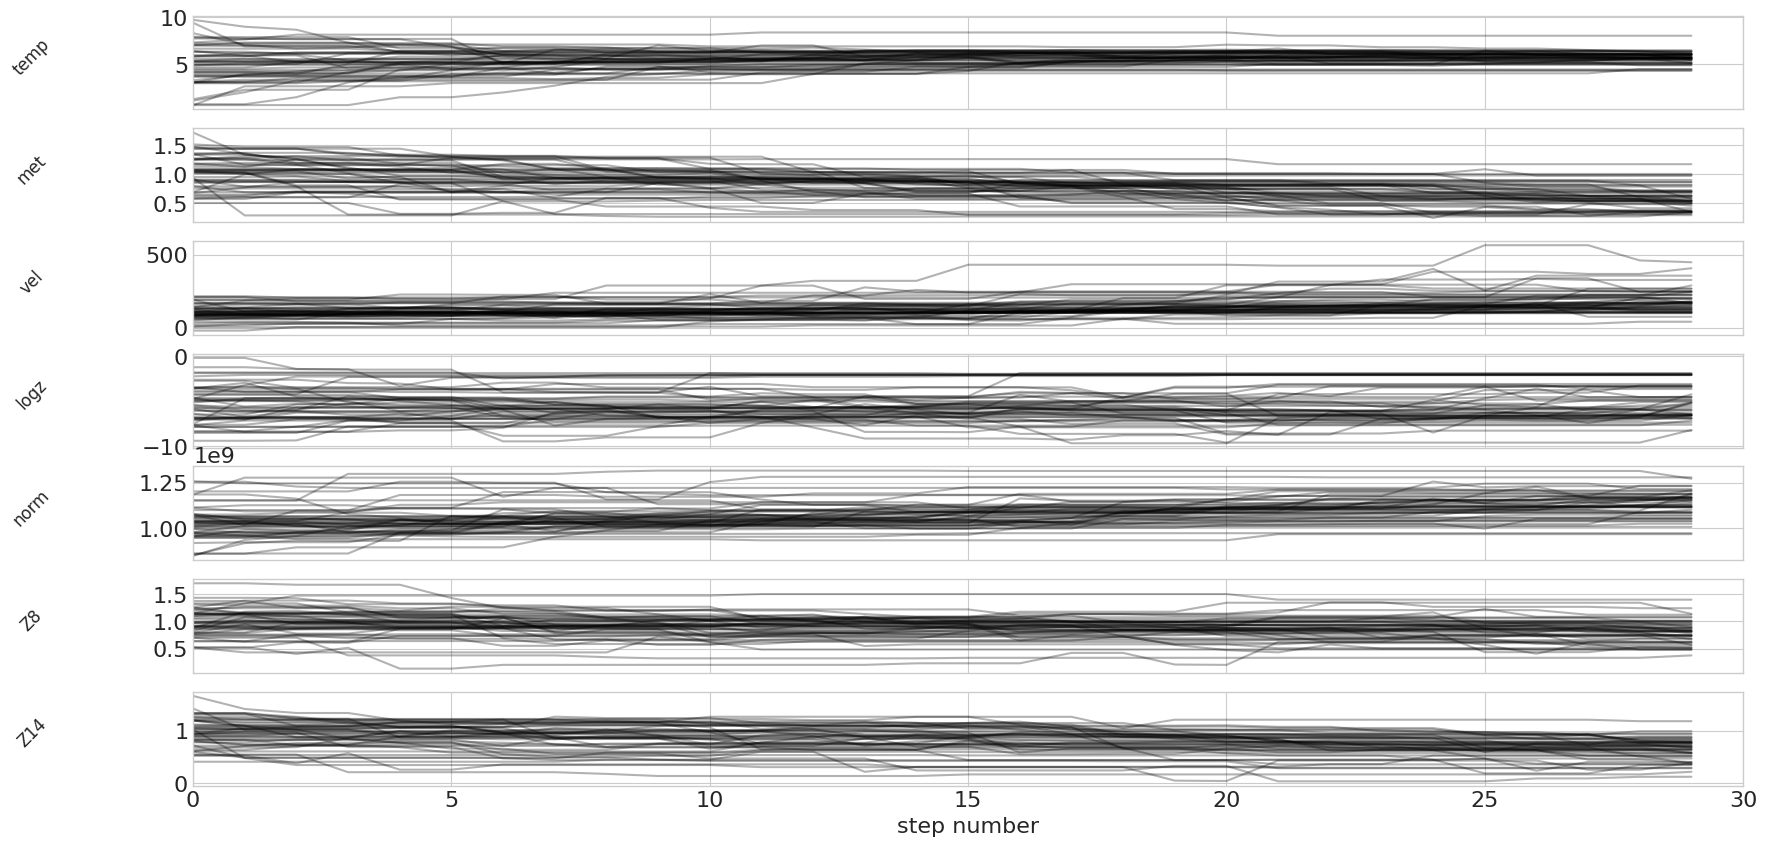

In [11]:
fit.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```Fit.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

<Figure size 640x480 with 0 Axes>

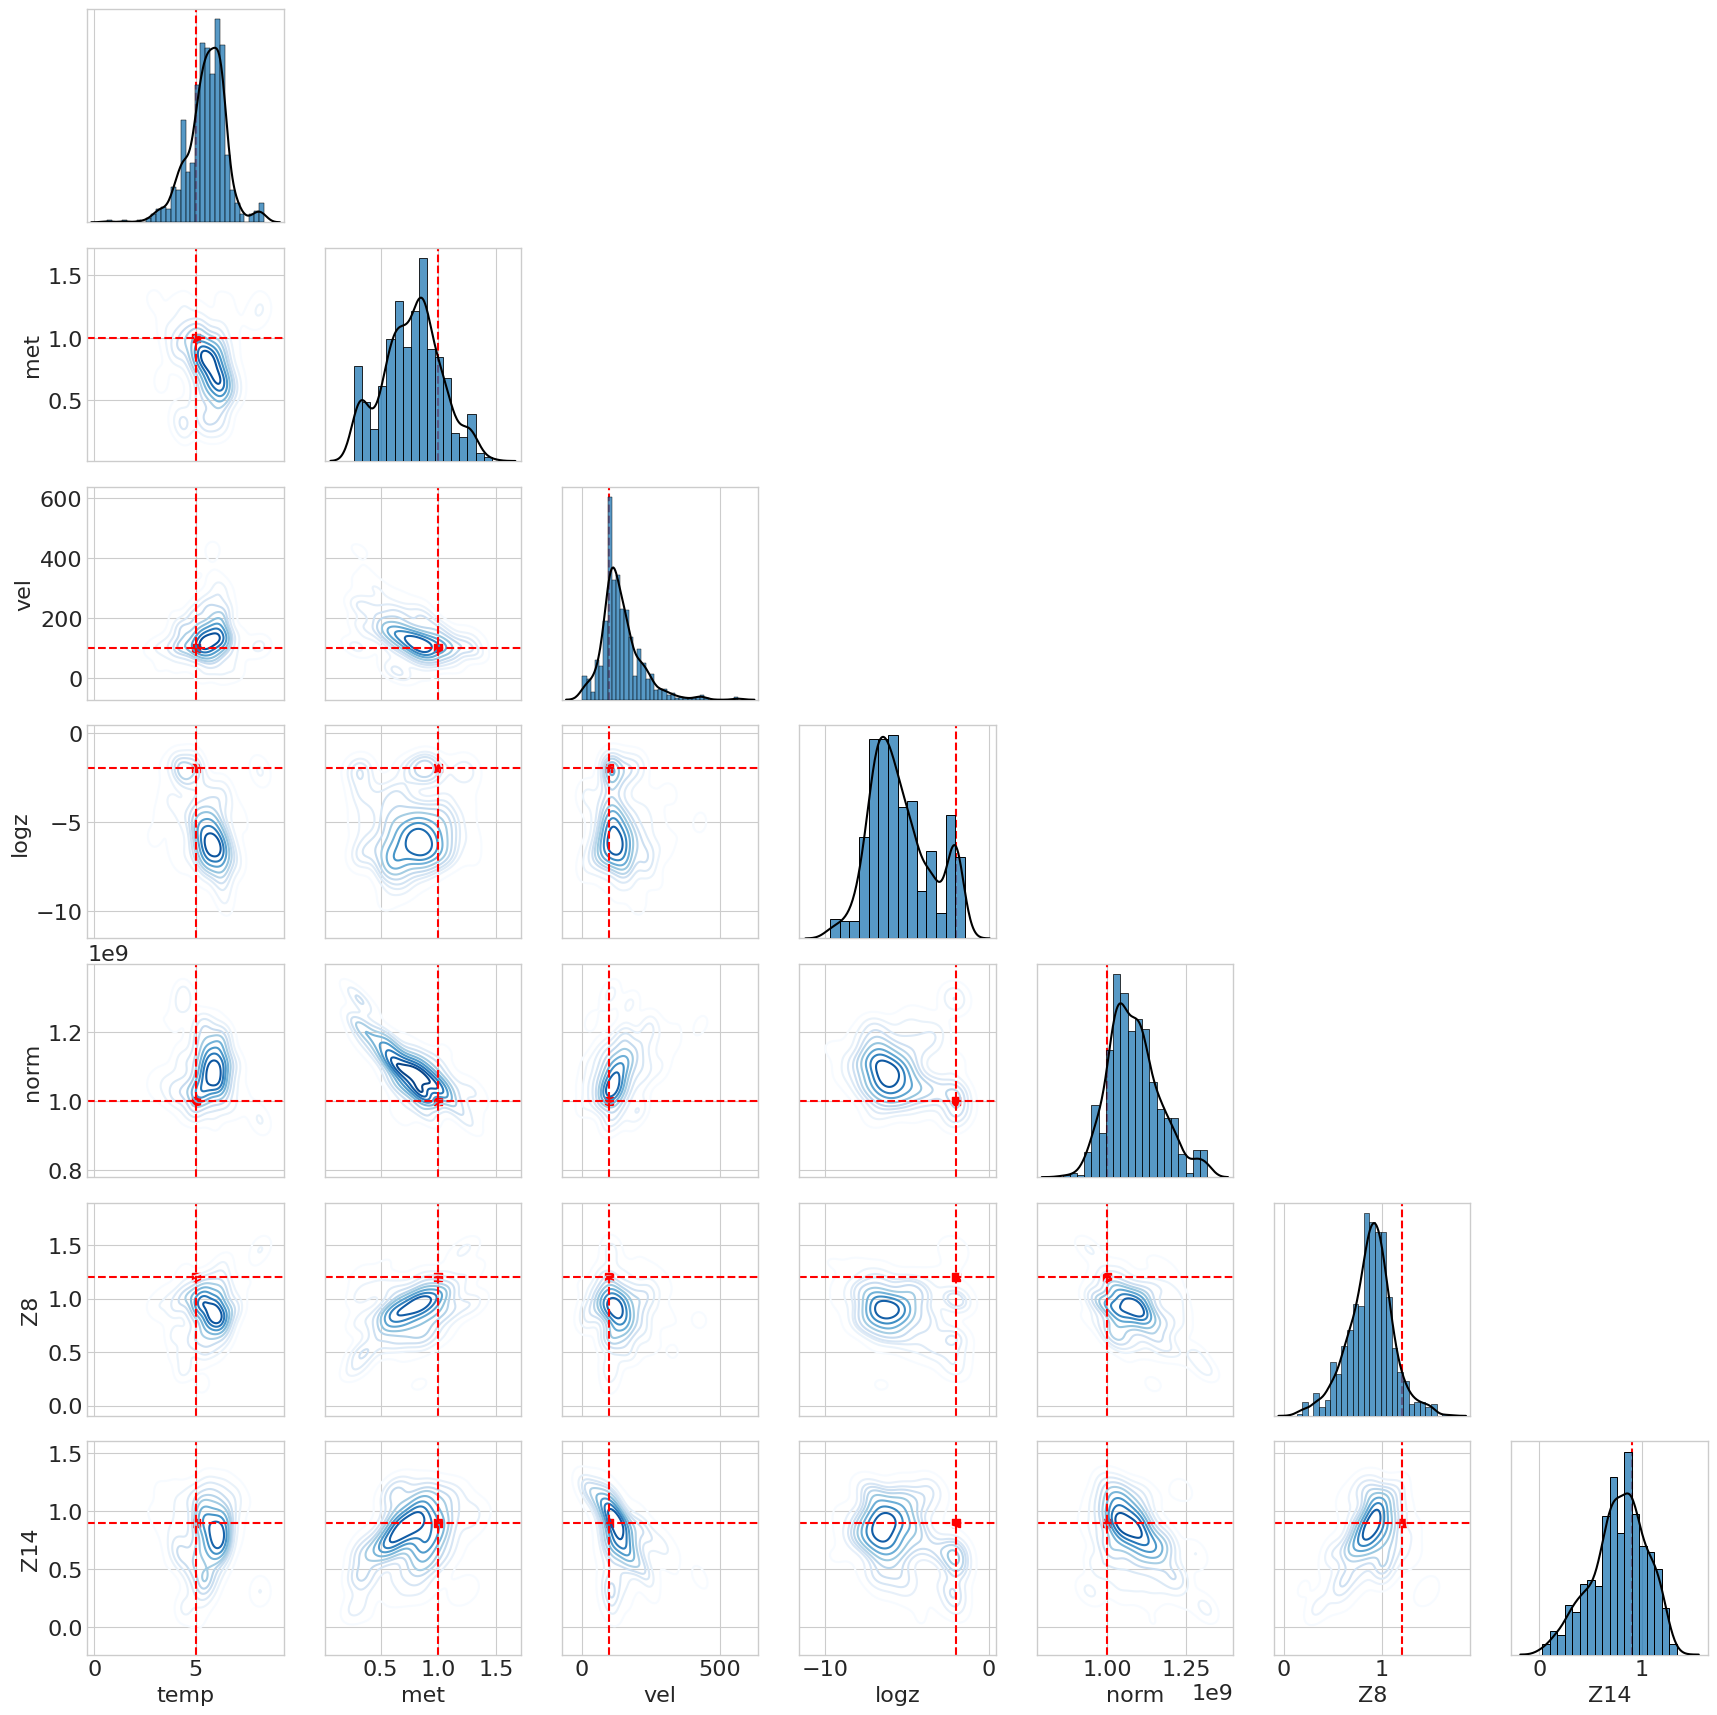

In [12]:
#true_val = [temp,   met,    vel,    logz    norm,   Z8,    Z14]
true_val =  [5,      1,      100,    -2,     1e10,   1.2,   0.9]

fit.cornerplot(600, thin=10, fitdir=None, true_values=true_val)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

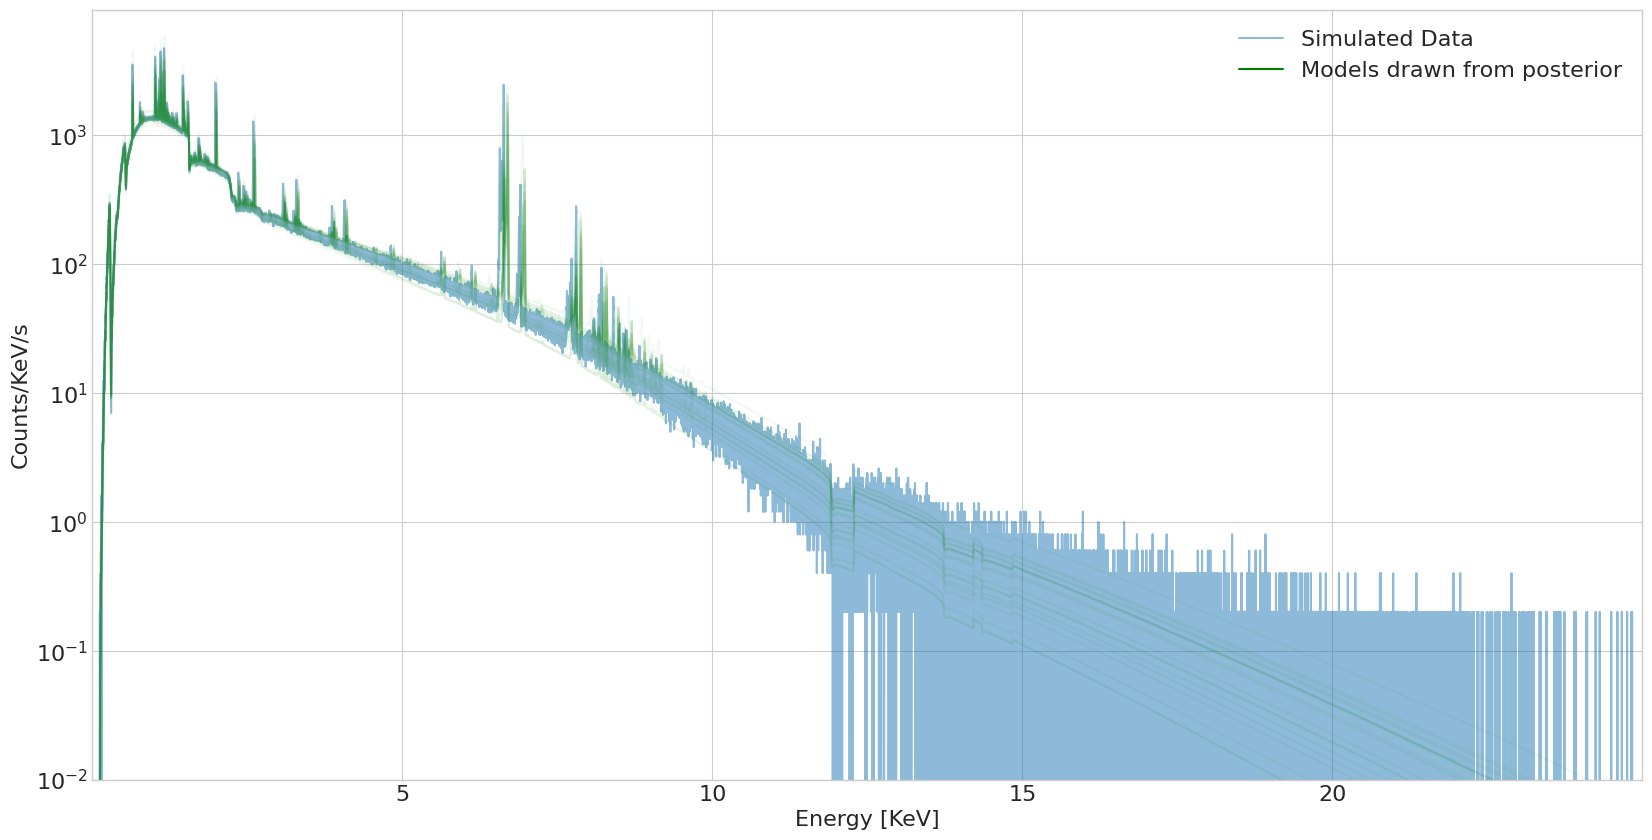

temp = 5.64778632708425_(-1.005842437952131)^(+0.6784728267031186)
met = 0.796409880476469_(-0.2655695101726059)^(+0.2191321284437584)
vel = 128.43236032898324_(-39.509963975824874)^(+77.35421337569454)
logz = -5.774854431160277_(-1.2589793393391302)^(+2.6736709004867905)
norm = 1081978678.0032825_(-68516215.0123564)^(+85403021.2108407)
Z8 = 0.8950848800811728_(-0.23298245133393758)^(+0.1756254721676116)
Z14 = 0.7867654937881479_(-0.3043646094541721)^(+0.26276045506798473)


In [14]:
'''This step can take a long time to run'''
fit.plot_spectrum(nsample=20)

## Fitting a Two-Temperature Model

Simulated data or real data can be model with a one temperuture model by  ```TwoTemp``` a subclass of Fit

The paramater that are fitted are the 
- First temperature in KeV  ```temp1``` (between 0.2 and 10 KeV)
- Second temperature in KeV  ```temp2``` (between 0.2 and 10 KeV)
- Metalicity [Z_solar] ```met```  (larger then 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- First normalisation ```norm1``` (between 1e5 and 1e15)
- Second normalisation ```norm2``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [2]:
#intial guess and prior for fit
prior = {
        'temp1': {'mu': 4.5,    'sigma': 2},
        'temp2': {'mu': 6,    'sigma': 2},
        'met' : {'mu': 1,    'sigma': .3},
        'vel' : {'mu': 100,  'sigma': 50},
        'logz': {'mu': -5,   'sigma': 2},
        'norm1': {'mu': 1e10, 'sigma': 5e9},
        'norm2': {'mu': 1.5e10, 'sigma': 5e9}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, ```prior``` indicates the intial values for the parameters and there Gaussion prior in the likelihood, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min``` > 0.1; ```e_max``` < 25).

```fdir_nn``` is the file directory to the trained neural networks and should match the path on your device.

In [3]:
#initialize the
fit_2t = TwoTemp(50, 800, prior, Luminosity_Distance=1e25, fdir_nn='/home/jmatthijss/spexai_code/neuralnetworks/', e_max=15)

Using cuda


### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF).

The data used for fitting can be read in from a FITS file of the observed data ```TwoTemp.load_data```, or can be simulated by the model with ```TwoTemp.sim_data(params)``` here ```params``` is a dictornary with the parameter names and there values.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [4]:
'''This step can take a long time to run'''
#reading in the response matrix file
fit_2t.combined_model.load_rm('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_he.rmf')

In [5]:
#reading in the effective area
fit_2t.combined_model.load_arf('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_point_he.arf')

In [6]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
fit_2t.combined_model.load_sparsematrix_x(n=200)

In [7]:
#create your own data
params = {'temp1':4, 'temp2':5.8, 'logz':-2, 'vel':100, 'met':1.2, 'norm1':8e9, 'norm2':1.2e10}
fit_2t.sim_data(params, exp_time=50000)

__Add aditional parameters__

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [8]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

### Run Ensemble Sampler Fit

Then after ensemble sampler has been fully intialized the data can be fitted with ```Fit.fit_spectra``` making use of ```emcee``` algorithm.
```TwoTemp.fit_spectra``` will also print the integrated autocorrelation time to give an indication of the burn-in time.

In [9]:
'''This step can take a long time to run'''
np.seterr(all="ignore")#ignore RuntimeWarning error prints
fit_2t.fit_spectra(add_prior=add_prior)

100%|██████████| 10/10 [01:29<00:00,  8.98s/it]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [       nan        nan        nan        nan        nan        nan
        nan        nan 0.99835724]

### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

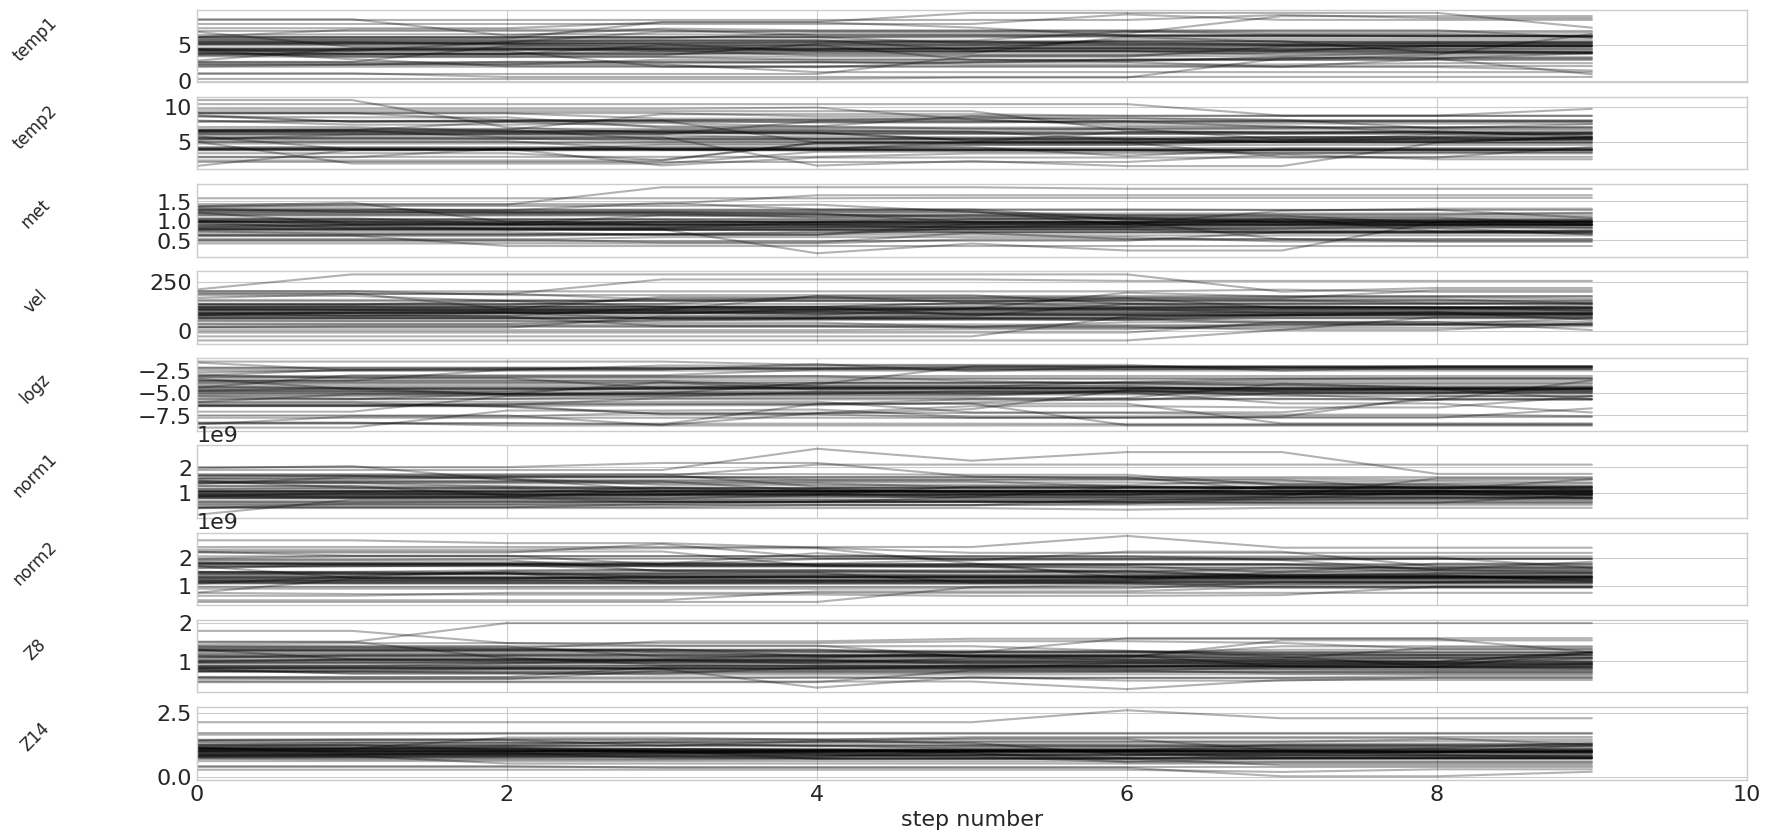

In [10]:
fit_2t.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```TwoTemp.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

<Figure size 640x480 with 0 Axes>

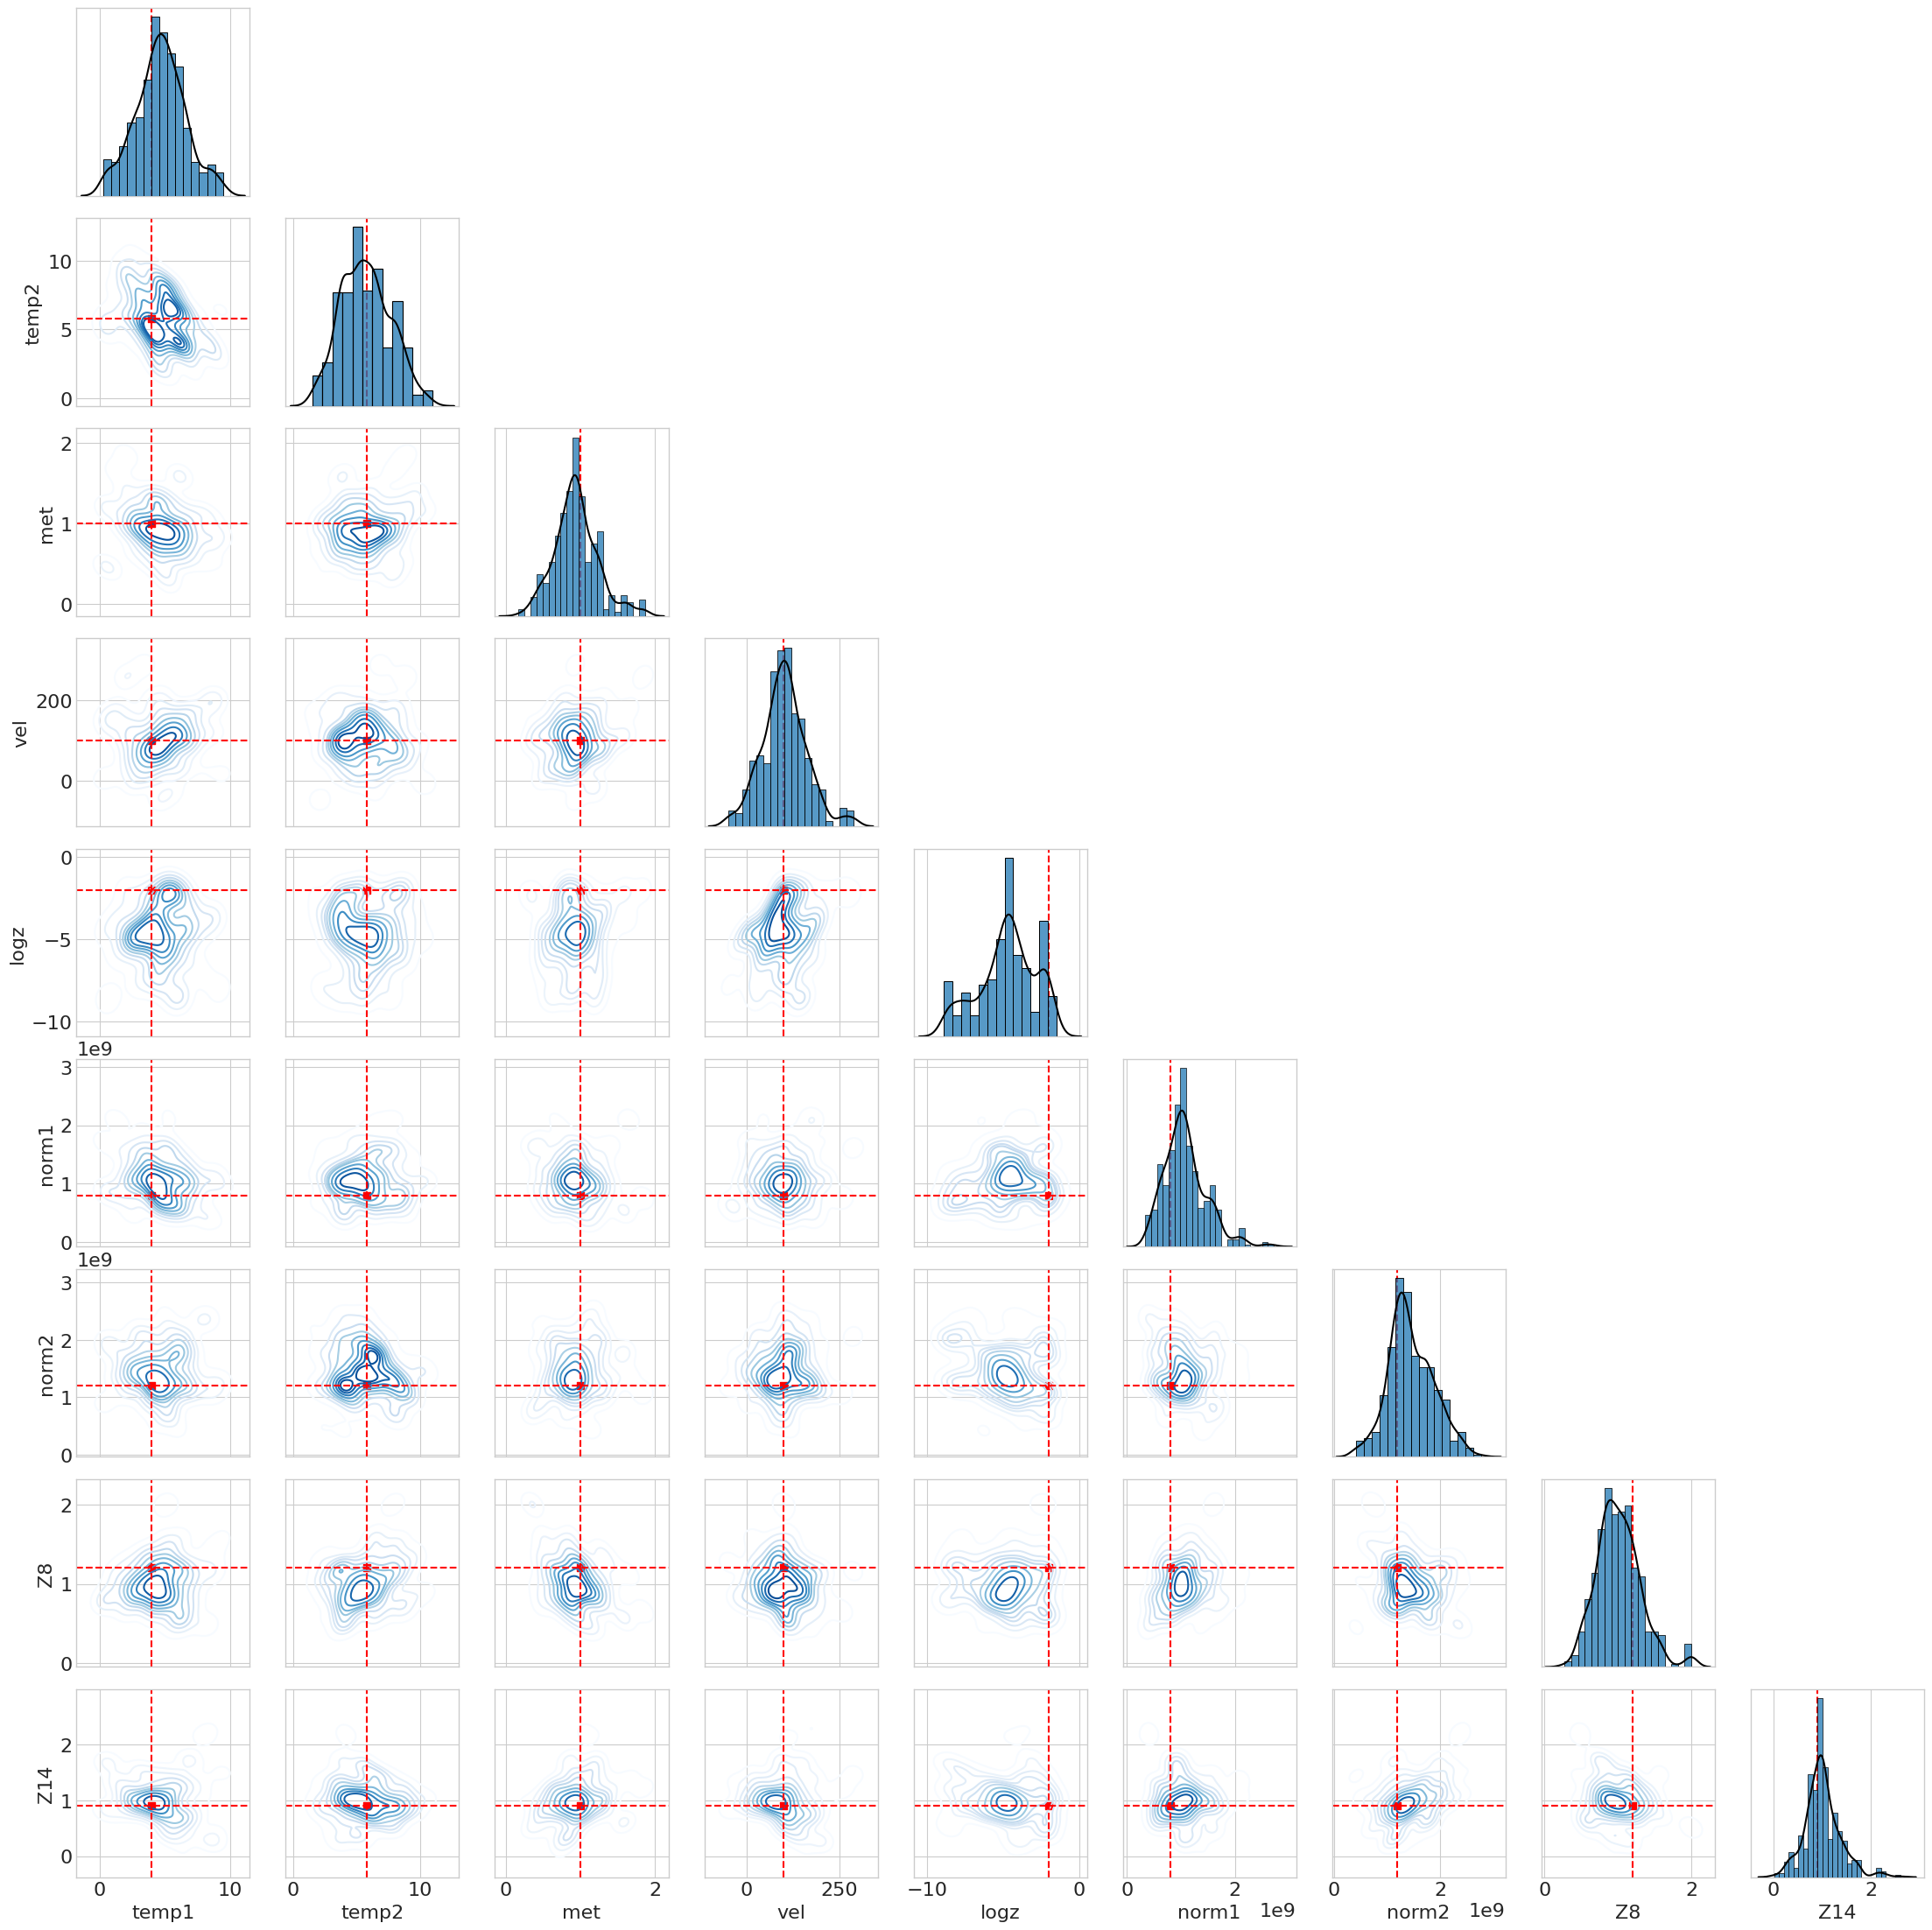

In [13]:
#true_val = [temp1, temp2,  met,    vel,    logz    norm1,  norm2,  Z8,    Z14]
true_val =  [4,     5.8,    1,      100,    -2,     8e9,    1.2e10, 1.2,   0.9]

fit_2t.cornerplot(600, thin=10, fitdir=None, true_values=true_val)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

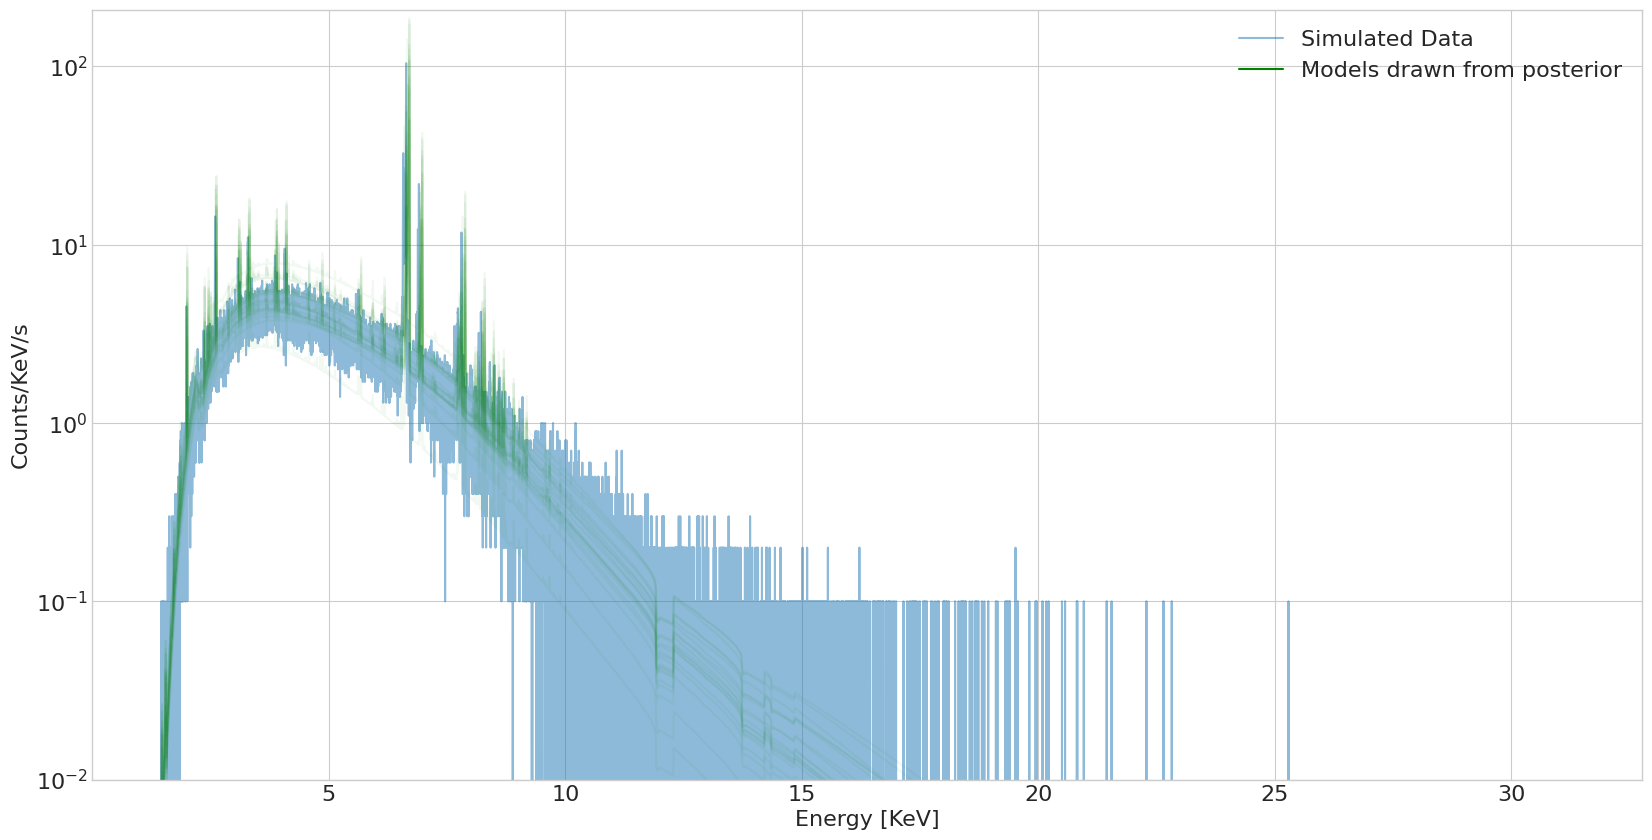

temp1 = 4.647993351492707_(-1.9740840295520554)^(+1.7338523886447588)
temp2 = 5.567872564337218_(-1.7095745808858336)^(+2.381506834834049)
met = 0.9304882996329642_(-0.24677893394433292)^(+0.2811717907803406)
vel = 100.01098952619493_(-57.09985560476859)^(+56.031179413428205)
logz = -4.573860933056725_(-2.0729377671908598)^(+2.1926097039559327)
norm1 = 1041194913.1573348_(-345724934.13435316)^(+411930480.73772335)
norm2 = 1375311541.647965_(-278656585.8010037)^(+539635264.0026107)
Z8 = 0.9817870638080959_(-0.2558412316527441)^(+0.2939252079558887)
Z14 = 0.9868510116237539_(-0.2683725186137347)^(+0.3349025232795839)


In [15]:
'''This step can take a long time to run'''
fit_2t.plot_spectrum(nsample=20)

## Fitting a Multi-Temperature Distribution Model

This uses a Subclass of ```Fit```, ```TempDist``` to fit a model with a multi-temperature distribution.

The temperature need to give a function that outputs a temperature grid and temperature distribution described by parameters. The output of the temperature grid should always be inbetween 0.2 and 10 KeV and linearly spaced and the distribution should always be normalized.

In this exapmle we look at a Normal Distribution for our temperature distribution, parametrized by a mean temperature and standard devitation.

The paramater that are fitted
- Mean Temperature in KeV ```mean_temp``` (between 0.2 and 10)
- Standard divation of Temperature in log(KeV) ```log_sd_temp``` (between -5, 0.3)
- Metalicity [Z_solar] ```met```  (larger then 0)
- Turbulent velocity in km/sec ```vel``` (between 0 and 600 km/sec)
- Redshift in log10(z) ```logz``` (between -10 and 1)
- Normalisation ```norm``` (between 1e5 and 1e15)

Additional parameter(s)
- Single element ```X``` abundace ratio with respect to Iron ```ZX```, where ```X``` is tha atom number (larger then 0)

The intial guess with there standard diviation can be put into the dictiornary of the ```prior```.

In [50]:
def normal_dist(params):
    '''
    Normal Distribution with stdev in logspace
    Parameters
    ----------
    params: dict
        dictionary with the keys of distribution parameters
        in this case 'mean_temp' and 'log_sd_temp'
    '''
    #intialize temperature grid
    low = max(params['mean_temp']-5*10**params['log_sd_temp'], 0.2)
    high = min(params['mean_temp']+5*10**params['log_sd_temp'], 10)
    temp_grid = np.linspace(low, high,  500)
    
    #Gaussion distribution
    mean = params['mean_temp']
    sd = 10**params['log_sd_temp']
    temp_dist = 1/(np.sqrt(2*np.pi)*sd**2) * np.exp(-0.5*((temp_grid-mean)/sd)**2)
    
    #normalize the function 
    temp_dist = temp_dist/np.sum(temp_dist*np.mean(np.diff(temp_grid)))
    return temp_grid, temp_dist

#define allowed interval of parameter of the distribution
interval = {
            'mean_temp': [0.2,10],
            'log_sd_temp'  : [-5, 0.3]
           }

The intial guess with there standard diviation of all the parameters that are fitted can be put into the dictiornary of the ```prior```.

In [51]:
#intial guess and prior for temp run
prior = {
        'mean_temp': {'mu': 4, 'sigma': 1},
        'log_sd_temp'  : {'mu': 0, 'sigma': 1},
        'met'      : {'mu': 0.6, 'sigma': .3},
        'vel'      : {'mu': 160, 'sigma': 25},
        'logz'     : {'mu': np.log10(0.017284),  'sigma': 0.05},
        'norm'     : {'mu': 2e10, 'sigma': 1e9}
        }

The ensemble samper can be intialized with ```nwalkers``` and ```nsteps``` for the walker to go through, the prior ```prior```, for the TempDist we need to give the function that returns a normalized temperature distribution with the temperature grid ```normal_dist``` and the bound interval of this ditributions parameter ```interval```, other parameter that can be initialized are the Luminosity Distance in m and the energy interval of the spectrum in KeV (```e_min, e_max```).

In [54]:
#initialize the
fit_dist = TempDist(40, 2, prior, normal_dist, interval, Luminosity_Distance=9.461e24, e_min=2, e_max=9, fdir_nn='/home/jmatthijss/spexai_code/neuralnetworks/')

Using cuda


### Reading in the FITS files

To be able to fit real data the response of the telescope can be read in by the FITS file, for the Response Matrix File (RMF), effective area response file (ARF) and the FITS file of the observed data.

In addition the response files there is a sparse matrix (```make_sparsex```) used for convulation that implements line broadening to the spectra. The speed an accuracy of the line broadening is strongly dependent on the kernel size of the convulolution ```n``` and the default ```n=300```, increasing ```n``` will make the line-broading more accurete but will also segnifcanly impact the speed.

In [55]:
'''This step can take a long time to run'''
#reading in the response matrix file
fit_dist.combined_model.load_rm('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_he.rmf')

In [56]:
#reading in the effective area
fit_dist.combined_model.load_arf('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_point_he.arf')

In [57]:
'''This step can take a long time to run'''
#initializing the sparse matrix for the convolution from line-broadening
fit_dist.combined_model.load_sparsematrix_x(n=200)

Now instead of simulating the data we are reading it in from a FITS file

In [58]:
#reading in the data
fit_dist.load_data('/home/jmatthijss/obs234_HP_obs234_all_det/obs234_HP_obs234_all_det_valign_gcor_he.pi')


#### Add aditional parameters

Single element abundace that differ with respect to the overall metalicity and Iron can be added in as extra parameter(s).
These are writen in the format ```'ZX'``` with ```X``` the atom number of the elements. ```add_prior``` gives the prior and intial  values of the added paramater(s).

In [59]:
#names of aditional fitted parameters 
add_prior = {'Z8':{'mu':1, 'sigma':.3},'Z14':{'mu':1, 'sigma':.3}}

Then after ensemble sampler has been fully intialized the data can be fitted with ```TempDist.fit_spectra``` making use of ```emcee``` algorithm.
```TempDist.fit_spectra``` will aslo print the the integrated autocorrelation time to give an indication of the burn-in time.

In [60]:
import torch
import matplotlib.pyplot as plt
def normal_dist(x , mean , sd):
    sd = torch.tensor(sd, dtype=torch.float32, device=x.device)
    prob_density = 1/(torch.sqrt(torch.tensor(2*np.pi, dtype=torch.float32, device=x.device)*sd**2)) * torch.exp(-0.5*((x-torch.tensor(mean, dtype=torch.float32, device=x.device))/sd)**2)
    return prob_density

In [63]:
params = {'Temperature [KeV]': 4, 'Temp Stdev log[KeV]': -2, 'Redshift [log(z)]': np.log10(0.017284), 'Velocity [km/sec]': 160, 'Metalicity [Fe/H]': .7, 'Normalisation': 2e10}

dict_abund = {}
for i in torch.arange(6,31):
    dict_abund[f'Z{i}'] = params['Metalicity [Fe/H]']
    for key in params.keys():
        if key == f'Z{i} [Z{i}/Fe]':
            dict_abund[f'Z{i}'] = params['Metalicity [Fe/H]']*params[f'Z{i} [Z{i}/Fe]']
low = max(params['Temperature [KeV]']-5*10**params['Temp Stdev log[KeV]'], 0.1)
high = min(params['Temperature [KeV]']+5*10**params['Temp Stdev log[KeV]'],10)
temp_grid = torch.linspace(low, high, 500, dtype=torch.float32, device='cuda')
temp_dist = normal_dist(temp_grid, params['Temperature [KeV]'], 10**params['Temp Stdev log[KeV]'])
temp_dist = temp_dist/torch.sum(temp_dist*torch.mean(torch.diff(temp_grid)))
with torch.no_grad():
    ymodel = fit_dist.combined_model(temp_grid, temp_dist, dict_abund, params['Redshift [log(z)]'], 
                    params['Normalisation'], params['Velocity [km/sec]'])
plt.plot(ymodel[fit_dist.intv].cpu().detach())
plt.yscale('log')
plt.ylim(1e-2,1e1)



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [64]:
'''This step can take a long time to run'''
np.seterr(all="ignore")#ignore RuntimeWarning error prints
fit_dist.fit_spectra(add_prior=add_prior)

100%|██████████| 2/2 [00:10<00:00,  5.33s/it]

[nan nan nan nan nan nan nan nan]


### Evaluating the fit results

The progress of the walker can be visualized in a timeseries giving the parameter values for each walker at each step in the chain.

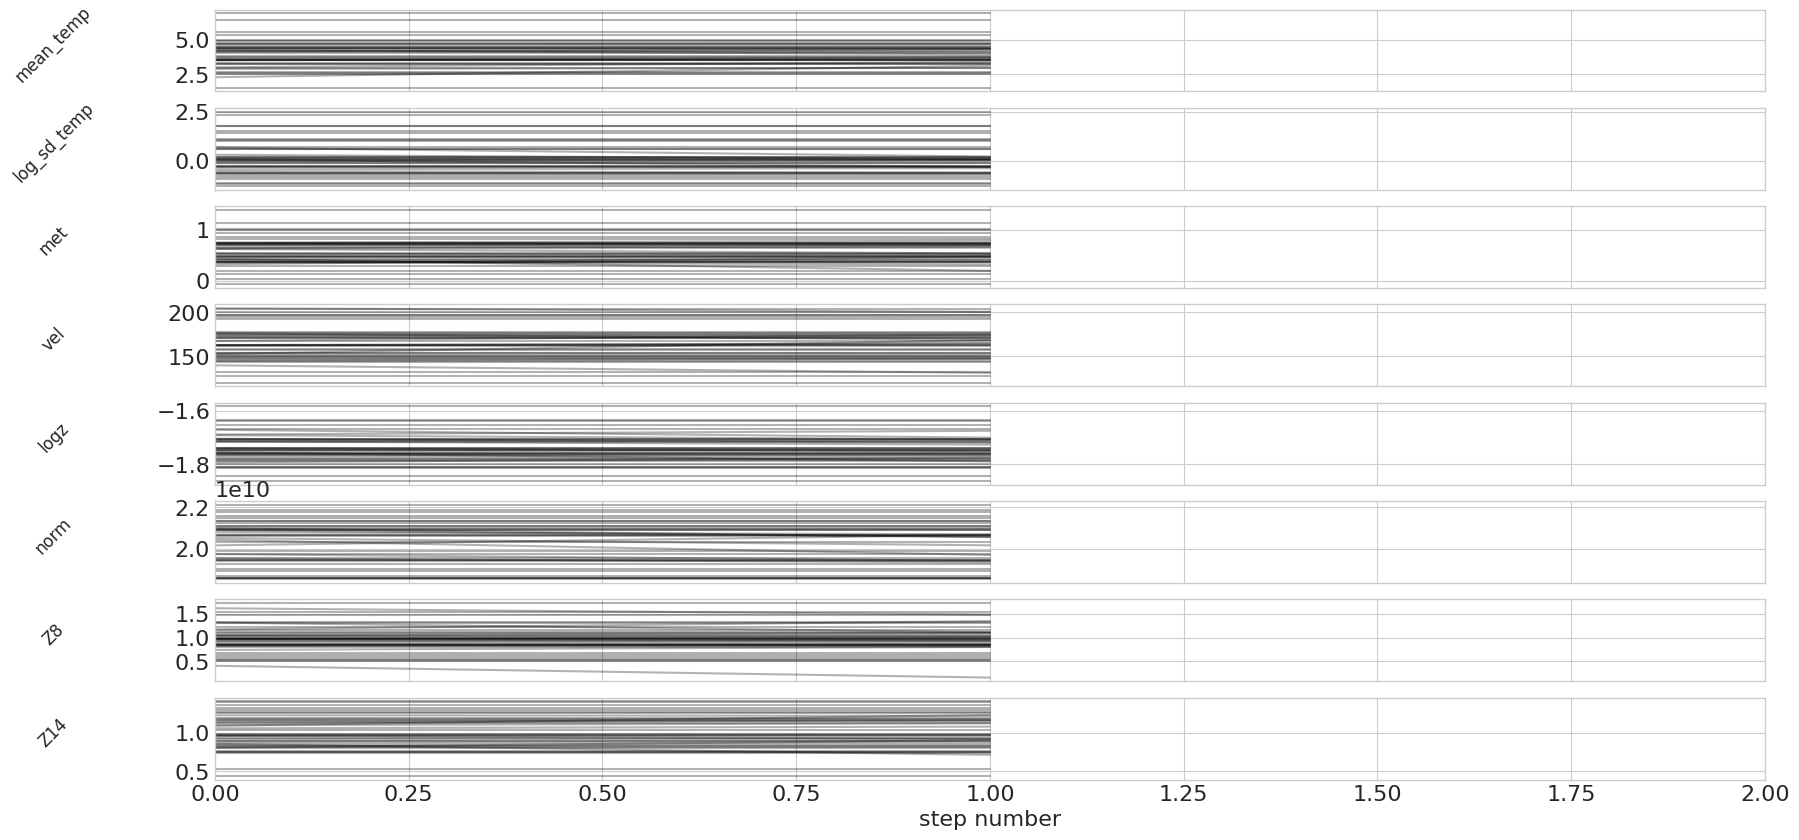

In [65]:
fit_dist.plot_timeseries()

The results of the fit can visualized with a cornerplot. ```TempDist.cornerplot``` is also able to save the sampled posterior in an .csv format by giving a directory name ```fitdir```.  In this example you discard the first ```100``` steps in the chain ```discard``` and only reading every 15th step ```thin```. The corner plot can also be oveploted with the true values of the parameters by giving a list ```true_values```, where the values shoud be same order as the prior.

<Figure size 640x480 with 0 Axes>

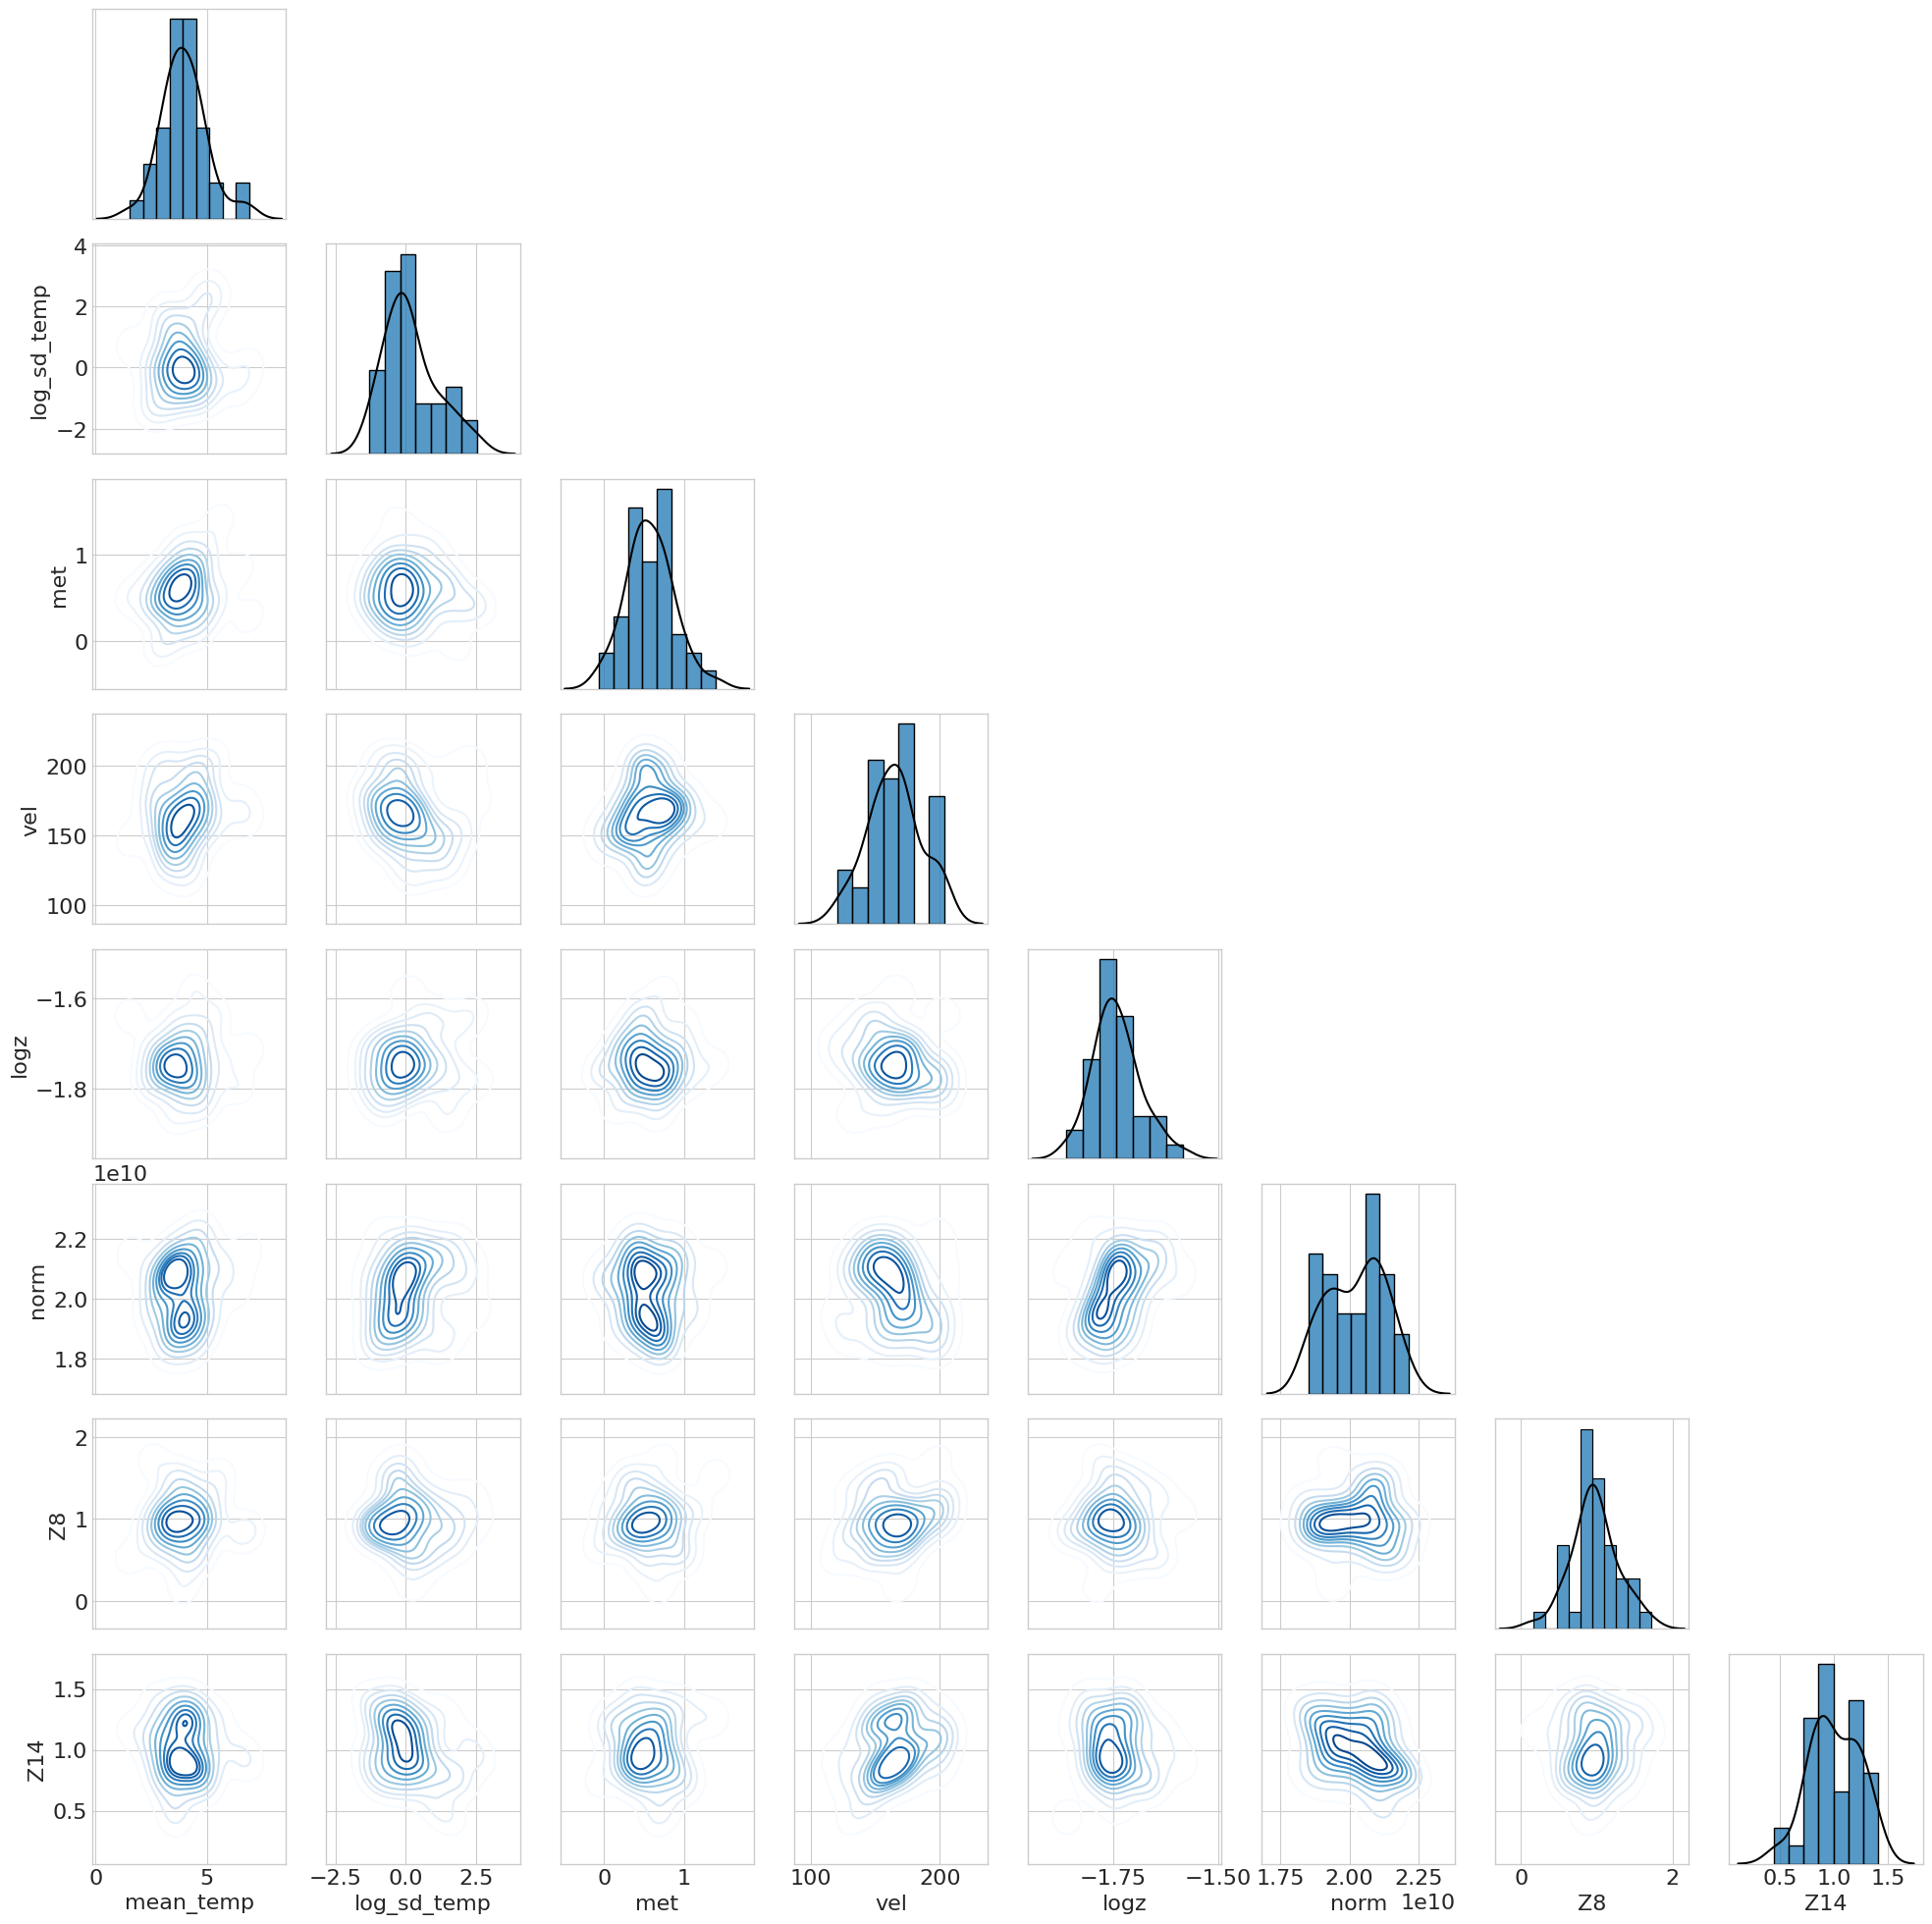

In [66]:
#true_val = mean_temp,  log_sd_temp,    met,    vel,    logz    norm,   Z8, Z14

fit_dist.cornerplot(1, thin=1, fitdir=None, true_values=None)

The fit results can be directly compared to the data by overplotting the fitted model with parameters drawn from the posterior to the observed data, the number of samples it overplots is given by ```nsample```. Also prints the mean and 1-sigma interval of the fitted parameters.

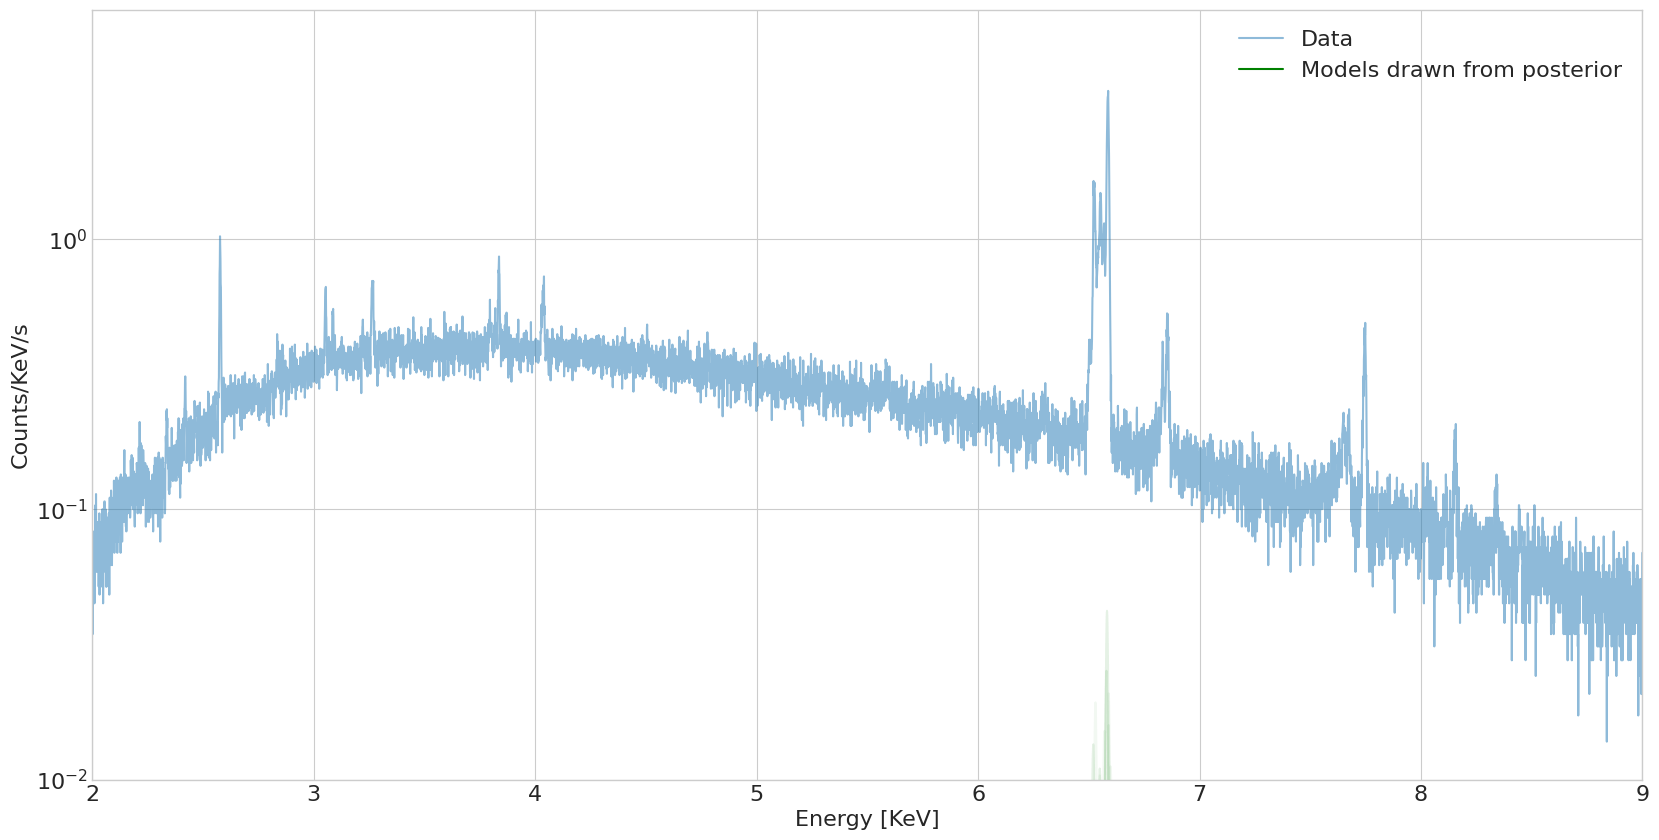

mean_temp = 3.8883123105110218_(-0.7435488706960998)^(+0.8432906510710372)
log_sd_temp = 0.03433329110306732_(-0.6845490437697495)^(+1.0712024557446467)
met = 0.5268917429722896_(-0.19417534345413956)^(+0.2878357690499008)
vel = 164.8818368453979_(-17.765203806943788)^(+24.365273882456876)
logz = -1.7483516260743364_(-0.03979015999560298)^(+0.0473075970772554)
norm = 20566065307.731094_(-1489404869.4983253)^(+748823888.3662376)
Z8 = 0.9621662394656528_(-0.2617827808048132)^(+0.3184105549229669)
Z14 = 0.9751088994332517_(-0.20000090292491113)^(+0.28198407165947104)


In [68]:
'''This step can take a long time to run'''
fit_dist.plot_spectrum(nsample=20)